In [1]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database


In [2]:
0.5*(u.degree**2).to(u.arcmin**2)

1800.0000000000002

In [3]:
#halo

In [4]:
H=350
FOV={'jswt':220*(u.arcmin**2)*124}
#make magnitude cuts
grism_cuts={'JSWT':{'NIRISS_F200W':[1, 27.], 'NIRISS_F115W':[1, 27.],\
                    'NIRISS_F150W':[1, 27.] }}

#the goods north field
#OINTS={'jswt':SkyCoord(ra="12:36:55", dec="62:14:15", unit=(u.hourangle, u.deg))}
POINTS={'jswt':SkyCoord(l=np.random.uniform(-180, 180, 10 )*u.degree,\
               b=np.random.uniform(-90, 90, 10)*u.degree, frame='galactic')}

In [5]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [6]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [54]:
def sample_pointings(scaleH, scaleL, NSAMPLE, volume_kind='exp'):
    ds=[]
    for c in tqdm(POINTS['jswt']):
        p= popsims.Pointing(coord=c,density= volume_kind)
        ds.append(p.draw_distances(1, 50000, \
                    scaleH, scaleL, nsample=1e4))
    ds=np.array(ds).flatten()
    return  np.random.choice(ds, int(NSAMPLE), replace=True)

def compute_normalized_volumes(scaleH, scaleL, volume_kind='exp'):
    vs=dict(zip(range(17, 42),np.zeros(len(range(17, 42)))))
    for c in tqdm(POINTS['jswt']):
        p= popsims.Pointing(coord=c,density= volume_kind)
        for s in range(17, 42):
            vs[s]+= popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                    0, DIST_LIMITS[s],scaleH, scaleL, \
                                   kind= volume_kind)
    
    return  vs

In [43]:
p=popsims.Pointing(coord=POINTS['jswt'])
p.mag_limits=grism_cuts['JSWT']
DIST_LIMITS=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [53]:
#DIST_LIMITS[17]

In [55]:
VOLUMES={'thin_disk': compute_normalized_volumes(350,2600, volume_kind='exp'),
         'thick_disk':compute_normalized_volumes(900, 3600, volume_kind='exp'),
         'halo': compute_normalized_volumes(900, 3600, volume_kind='spheroid'),
}

100%|██████████| 10/10 [00:00<00:00, 88.96it/s]


In [56]:
VOLUMES

{'thin_disk': {17: 35581225962.093254,
  18: 35581225635.095604,
  19: 35581187839.83596,
  20: 35580645026.023094,
  21: 35576828920.72847,
  22: 35560210701.26635,
  23: 35508530730.976135,
  24: 35383798041.155594,
  25: 35139204999.10299,
  26: 34739887202.12843,
  27: 34189495954.04072,
  28: 33542417301.517803,
  29: 32885627502.04444,
  30: 32294416749.18564,
  31: 31781241134.221252,
  32: 31250872961.695747,
  33: 29534011878.700703,
  34: 26324860489.948673,
  35: 21401640228.745636,
  36: 14843263038.224215,
  37: 8161542743.5826025,
  38: 2758844834.636356,
  39: 511446627.93885314,
  40: 48972753.53780192,
  41: 1209081.2826036327},
 'thick_disk': {17: 170636422701.16968,
  18: 170623851756.017,
  19: 170525650163.26813,
  20: 170129479214.24567,
  21: 169081590317.74228,
  22: 166980944227.0603,
  23: 163500792338.52002,
  24: 158503366108.83582,
  25: 152132569189.6829,
  26: 144840295066.81653,
  27: 137302496895.09752,
  28: 130238596195.59875,
  29: 124203558979.01347

In [8]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    scaleH=kwargs.get('h', 350)
    scaleL=kwargs.get('l', 2600)
    kind=kwargs.get('kind', 'exp')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    
    volume_kind=kind
    if kind!='exp':
        volume_kind='spheroid'

    galactic_dists=sample_pointings(scaleH, scaleL, 1e6, volume_kind= volume_kind)
    
    dff=popsims.create_pop(bfraction=0.2,\
                         model= model,\
                           l=list(POINTS['jswt'].galactic.l.radian),
                           b=list(POINTS['jswt'].galactic.b.radian),
                           absmag_keys=mag_keys, \
                           nsample=int(1e6),
                           distances=galactic_dists,
                  poptype='dwarfs')
    
    scale=np.nanmedian(dff.scale)
    df_cut= make_cuts(dff,cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    
    #compute volumes
    p= popsims.Pointing(coord=POINTS['jswt'][0])
    dct= get_average_distance_limits(p, cuts, survey=survey)
    for spt in tqdm(spgrid):
        sptvol=popsims.volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., dct[spt],scaleH, scaleL, kind= volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [10]:
def get_numbers_by_model(model='burrows1997'):
    thin_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', model=model)
    thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=900, l=3600, model=model)
    halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', kind='halo', model=model)
    
    return {'thin': thin_number, 'thick': thick_number, 'halo': halo_number}

In [11]:
b97=get_numbers_by_model(model='burrows1997')
b01=get_numbers_by_model(model='burrows2001')
b03=get_numbers_by_model(model='baraffe2003')

100%|██████████| 25/25 [00:00<00:00, 169.51it/s]


In [12]:
import collections
isinstance(list(POINTS['jswt'].galactic.l.radian), collections.Sequence)

True

In [13]:
POINTS['jswt'].galactic.l.radian

array([1.5233736 , 2.00571182, 4.53560718, 1.25414184, 4.31544773,
       4.62768075, 1.66811525, 3.94708713, 6.08209618, 2.99440632])

In [42]:
DIST_LIMITS

{10: 497344.2190417317,
 11: 320776.0645877478,
 12: 213386.0390108638,
 13: 147985.28642706288,
 14: 106948.96906641146,
 15: 80379.67034098422,
 16: 62624.40163129896,
 17: 50383.36152218183,
 18: 41172.40901410765,
 19: 34202.940266055586,
 20: 29058.309529560633,
 21: 25114.032713899647,
 22: 21982.12561143497,
 23: 19425.19671638913,
 24: 17302.107386586013,
 25: 15531.791890831417,
 26: 14068.227289752898,
 27: 12882.987242099143,
 28: 11953.121096807132,
 29: 11252.146230325681,
 30: 10741.55371947136,
 31: 10360.196019872204,
 32: 10010.420806714708,
 33: 9084.028896190883,
 34: 7813.193689762531,
 35: 6378.753160421809,
 36: 4835.124601411773,
 37: 3308.8539707973496,
 38: 1751.0265569842863,
 39: 735.9355554439614,
 40: 279.2000593309919,
 41: 73.92311650864852,
 42: 12.39046603819139}

In [17]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} ".format(distlimits[x]/1000) for x in locs]

In [18]:
#visualize 
#sns.set_palette('cividis')

In [19]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))
conversion_area=1/((7.5*u.deg**2).to(u.arcmin**2))

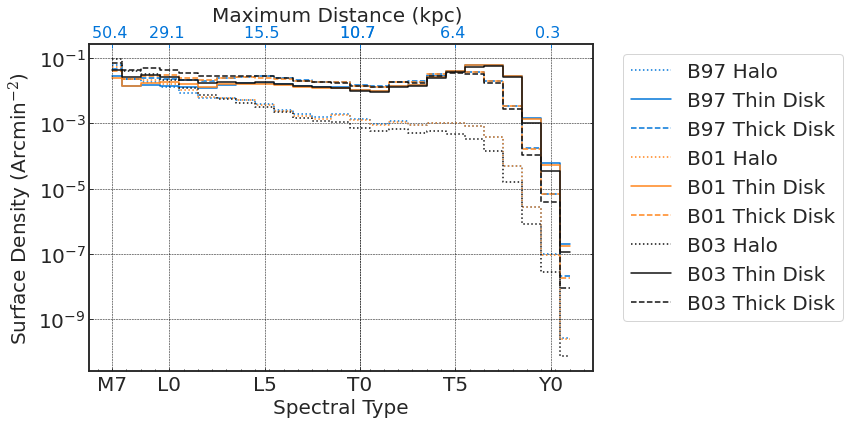

In [37]:
fig, ax=plt.subplots(figsize=(12, 6))
plt.step(np.arange(17, 42), b97['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#0074D9', label='B97 Halo')
plt.step(np.arange(17, 42), b97['thin']['counts']*conversion_area, \
          where='mid',  linestyle='-', color='#0074D9', label='B97 Thin Disk')
plt.step(np.arange(17, 42), b97['thick']['counts']*(0.12)*conversion_area, \
          where='mid',  linestyle='--', color='#0074D9',label='B97 Thick Disk')

plt.step(np.arange(17, 42), b01['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#FF851B', label='B01 Halo')
plt.step(np.arange(17, 42), b01['thin']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  label='B01 Thin Disk')
plt.step(np.arange(17, 42), b01['thick']['counts']*(0.12)*conversion_area, \
        where='mid', linestyle='--', color='#FF851B',   label='B01 Thick Disk')

plt.step(np.arange(17, 42), b03['halo']['counts']*(1/400)*conversion_area,\
         where='mid', linestyle='dotted', color='#111111', label='B03 Halo')
plt.step(np.arange(17, 42), b03['thin']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#111111',  label='B03 Thin Disk')
plt.step(np.arange(17, 42), b03['thick']['counts']*(0.12)*conversion_area, \
         where='mid', linestyle='--', color='#111111', label='B03 Thick Disk')


ax.set(xlabel='Spectral Type', \
       ylabel=r'Surface Density (Arcmin$^{-2}$)', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')

ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([17, 20, 25, 30, 30, 35, 40])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, ave_limits ), fontsize=16)
ax2.tick_params(colors='#0074D9', which='both') 
ax2.set_xlabel('Maximum Distance (kpc) ')
ax2.grid()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
ax.grid( axis='y',  which='major')
ax.minorticks_on()
plt.savefig(popsims.FIGURES+'/jswt_counts.pdf', dpi=600)

In [21]:
np.average(b97['halo']['counts']*(1/400)*conversion_area)

<Quantity 0.00639764 1 / arcmin2>

In [22]:
np.average(b03['halo']['counts']*(1/400)*conversion_area)

<Quantity 0.00918768 1 / arcmin2>

In [23]:
np.average(b01['halo']['counts']*(1/400)*conversion_area)

<Quantity 0.00638072 1 / arcmin2>

In [24]:
np.average(b97['thick']['counts']*(0.12)*conversion_area)

<Quantity 0.02053594 1 / arcmin2>

In [25]:
np.average(b03['thick']['counts']*(0.12)*conversion_area)

<Quantity 0.02423645 1 / arcmin2>

In [26]:
np.average(b01['thick']['counts']*(0.12)*conversion_area)

<Quantity 0.02056585 1 / arcmin2>

In [27]:
np.average(b01['thin']['counts']*conversion_area)

<Quantity 0.01869852 1 / arcmin2>

In [28]:
np.average(b03['thin']['counts']*conversion_area)

<Quantity 0.02070011 1 / arcmin2>

In [29]:
np.average(b97['thin']['counts']*conversion_area)

<Quantity 0.01860001 1 / arcmin2>

In [30]:
POINTS['jswt'].galactic.l.degree,  POINTS['jswt'].galactic.b.degree

(array([ 87.28287801, 114.91882194, 259.87114866,  71.85703434,
        247.25694138, 265.14657562,  95.57596343, 226.15143374,
        348.47844198, 171.56684425]),
 array([ 33.71880276,  29.66332258, -47.05270506,  85.51535808,
        -60.27070672,   4.46113826,  48.5476817 ,  57.084262  ,
        -74.5918952 ,  21.73876037]))

In [31]:
np.nansum(b97['halo']['counts']*(1/400)), np.nansum(b03['halo']['counts']*(1/400))

(4318.406573197864, 6201.6863079641835)

In [32]:
np.nansum(b01['halo']['counts']*(1/400))

4306.983735634258

In [33]:
np.nansum(b01['thick']['counts']*(0.12)), np.nansum(b03['thick']['counts']*(0.12))

(13881.945625979484, 16359.606589138291)

In [34]:
np.nansum(b97['thick']['counts']*(0.12))

13861.759622055926

In [35]:
np.nansum(b01['thin']['counts']), np.nansum(b03['thin']['counts'])

(12621.501608588133, 13972.573888801331)

In [36]:
np.nansum(b97['thin']['counts'])

12555.004271838601

In [17]:
import numpy as np
import astropy.units as u
d=1*u.Mpc

In [25]:
dmods

array([23.49485002, 25.        , 26.50514998, 27.38560627, 28.01029996,
       28.49485002])